## Imports

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

import sys
import pickle
import wandb

import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.utils import to_networkx
import torch.nn as nn
from torch_geometric.nn import GCNConv, Sequential
import networkx as nx

from utils.miscellaneous import read_config
from utils.miscellaneous import create_folder_structure_MLPvsGNN
from utils.miscellaneous import initalize_random_generators

from training.train import training
from training.test import testing

from utils.visualization import plot_R2, plot_loss

wandb.init(project="Unrolling WDNs", entity="albert-sola9")

### Parse configuration file + initializations


In [56]:
# read config files
cfg = read_config("config_unrolling_GNN.yaml")
# create folder for results
exp_name = cfg['exp_name']
data_folder = cfg['data_folder']
results_folder = create_folder_structure_MLPvsGNN(cfg, parent_folder='./experiments')


all_wdn_names = cfg['networks']
initalize_random_generators(cfg, count=0)

# initialize pytorch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
print(device)
#torch.set_num_threads(12)

Creating folder: ./experiments/unrolling_GNN_WDN0009
cuda:0


In [57]:
# TO DO: at the moment I am not using the parsed values for batch size and num_epochs ;
# I am not using alpha as well because the loss has no "smoothness" penalty (yet)
batch_size = cfg['trainParams']['batch_size']
alpha = cfg['lossParams']['alpha']
res_columns = ['train_loss', 'valid_loss','test_loss','max_train_loss', 'max_valid_loss','max_test_loss', 'min_train_loss', 'min_valid_loss','min_test_loss','r2_train', 'r2_valid',
			   'r2_test','total_params','total_time','test_time','num_epochs']

# Functions

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator,TransformerMixin

class PowerLogTransformer(BaseEstimator,TransformerMixin):
	def __init__(self,log_transform=False,power=4,reverse=True):
		if log_transform == True:
			self.log_transform = log_transform
			self.power = None
		else:
			self.power = power
			self.log_transform = None
		self.reverse=reverse
		self.max_ = None
		self.min_ = None

	def fit(self,X,y=None):
		self.max_ = np.max(X)
		self.min_ = np.min(X)
		return self

	def transform(self,X):
		if self.log_transform==True:
			if self.reverse == True:
				return np.log1p(self.max_-X)
			else:
				return np.log1p(X-self.min_)
		else:
			if self.reverse == True:
				return (self.max_-X)**(1/self.power )
			else:
				return (X-self.min_)**(1/self.power )

	def inverse_transform(self,X):
		if self.log_transform==True:
			if self.reverse == True:
				return (self.max_ - np.exp(X))
			else:
				return (np.exp(X) + self.min_)
		else:
			if self.reverse == True:
				return (self.max_ - X**self.power )
			else:
				return (X**self.power + self.min_)

class GraphNormalizer:
	def __init__(self, x_feat_names=['elevation','base_demand','base_head'],
				 ea_feat_names=['diameter','length','roughness'], output='pressure'):
		# store
		self.x_feat_names = x_feat_names
		self.ea_feat_names = ea_feat_names
		self.output = output

		# create separate scaler for each feature (can be improved, e.g., you can fit a scaler for multiple columns)
		self.scalers = {}
		for feat in self.x_feat_names:
			if feat == 'elevation':
				self.scalers[feat] = PowerLogTransformer(log_transform=True,reverse=False)
			else:
				self.scalers[feat] = MinMaxScaler()
		self.scalers[output] = PowerLogTransformer(log_transform=True,reverse=True)
		for feat in self.ea_feat_names:
			if feat == 'length':
				self.scalers[feat] = PowerLogTransformer(log_transform=True,reverse=False)
			else:
				self.scalers[feat] = MinMaxScaler()

	def fit(self, graphs):
		''' Fit the scalers on an array of x and ea features
		'''
		x, y, ea = from_graphs_to_pandas(graphs)
		for ix, feat in enumerate(self.x_feat_names):
			self.scalers[feat] = self.scalers[feat].fit(x[:,ix].reshape(-1,1))
		self.scalers[self.output] = self.scalers[self.output].fit(y.reshape(-1,1))
		for ix, feat in enumerate(self.ea_feat_names):
			self.scalers[feat] = self.scalers[feat].fit(ea[:,ix].reshape(-1,1))
		return self

	def transform(self, graph):
		''' Transform graph based on normalizer
		'''
		graph = graph.clone()
		for ix, feat in enumerate(self.x_feat_names):
			temp = graph.x[:,ix].numpy().reshape(-1,1)
			graph.x[:,ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
		for ix, feat in enumerate(self.ea_feat_names):
			temp = graph.edge_attr[:,ix].numpy().reshape(-1,1)
			graph.edge_attr[:,ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
		graph.y = torch.tensor(self.scalers[self.output].transform(graph.y.numpy().reshape(-1,1)).reshape(-1))
		return graph

	def inverse_transform(self, graph):
		''' Perform inverse transformation to return original features
		'''
		graph = graph.clone()
		for ix, feat in enumerate(self.x_feat_names):
			temp = graph.x[:,ix].numpy().reshape(-1,1)
			graph.x[:,ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
		for ix, feat in enumerate(self.ea_feat_names):
			temp = graph.edge_attr[:,ix].numpy().reshape(-1,1)
			graph.edge_attr[:,ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
		graph.y = torch.tensor(self.scalers[self.output].inverse_transform(graph.y.numpy().reshape(-1,1)).reshape(-1))
		return graph

	def transform_array(self,z,feat_name):
		'''
			This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
		'''
		return torch.tensor(self.scalers[feat_name].transform(z).reshape(-1))

	def inverse_transform_array(self,z,feat_name):
		'''
			This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
		'''
		return torch.tensor(self.scalers[feat_name].inverse_transform(z))

def from_graphs_to_pandas(graphs, l_x=3, l_ea=3):
	x = []
	y = []
	ea = []
	for i, graph in enumerate(graphs):
		x.append(graph.x.numpy())
		y.append(graph.y.reshape(-1,1).numpy())
		ea.append(graph.edge_attr.numpy())
	return np.concatenate(x,axis=0),np.concatenate(y,axis=0),np.concatenate(ea,axis=0)

In [59]:
from models.virtual_nodes import add_virtual_nodes
from torch_geometric.utils import to_undirected

# constant indexes for node and edge features
HEAD_INDEX = 0
BASEDEMAND_INDEX = 1
TYPE_INDEX = 2
DIAMETER_INDEX = 0
LENGTH_INDEX = 1
ROUGHNESS_INDEX = 2
FLOW_INDEX = 3

def load_raw_dataset(wdn_name, data_folder):
	'''
	Load tra/val/data for a water distribution network datasets
	-------
	wdn_name : string
		prefix of pickle files to open
	data_folder : string
		path to datasets
	'''

	data_tra = pickle.load(open(f'{data_folder}/train/{wdn_name}.p', "rb"))
	data_val = pickle.load(open(f'{data_folder}/valid/{wdn_name}.p', "rb"))
	data_tst = pickle.load(open(f'{data_folder}/test/{wdn_name}.p', "rb"))

	return data_tra, data_val, data_tst

def create_dataset(database, normalizer=None, HW_rough_minmax=[60, 150],add_virtual_reservoirs=False, output='pressure'):
	'''
	Creates working datasets dataset from the pickle databases
	------
	database : list
		each element in the list is a pickle file containing Data objects
	normalization: dict
		normalize the dataset using mean and std
	'''
	# Roughness info (Hazen-Williams) / TODO: remove the hard_coding
	minR = HW_rough_minmax[0]
	maxR = HW_rough_minmax[1]

	graphs = []

	for i in database:
		graph = torch_geometric.data.Data()

		# Node attributes
		# elevation_head = i.elevation + i.base_head
		# elevation_head = i.elevation.clone()
		# elevation_head[elevation_head == 0] = elevation_head.mean()

		min_elevation = min(i.elevation[i.type_1H == 0])
		head = i.pressure + i.base_head + i.elevation
		# elevation_head[i.type_1H == 1] = head[i.type_1H == 1]
		# elevation = elevation_head - min_elevation

		# base_demand = i.base_demand * 1000  # convert to l/s
		# graph.x = torch.stack((i.elevation, i.base_demand, i.type_1H*i.base_head), dim=1).float()
		graph.x = torch.stack((i.elevation+i.base_head, i.base_demand, i.type_1H), dim=1).float()
		# graph.x = torch.stack((i.elevation+i.base_head, i.base_demand, i.type_1H), dim=1).float()

		# Position and ID
		graph.pos = i.pos
		graph.ID = i.ID

		# Edge index (Adjacency matrix)
		graph.edge_index = i.edge_index

		# Edge attributes
		diameter = i.diameter
		length = i.length
		roughness = i.roughness
		graph.edge_attr = torch.stack((diameter, length, roughness), dim=1).float()

		# pressure = i.pressure
		# graph.y = pressure.reshape(-1,1)

		# Graph output (head)
		if output == 'head':
			graph.y  = head[i.type_1H == 0].reshape(-1, 1)
		else:
			graph.y = i.pressure[i.type_1H == 0].reshape(-1, 1)
			# pressure[i.type_1H == 1] = 0 # THIS HAS TO BE DONE BETTER
			# graph.y = pressure


		# normalization
		if normalizer is not None:
			graph = normalizer.transform(graph)

		if add_virtual_reservoirs:

			graph.x = torch.nn.functional.pad(graph.x, (0, 1))
			graph.edge_attr = torch.nn.functional.pad(graph.edge_attr, (0, 1))
			add_virtual_nodes(graph)
		graphs.append(graph)
	A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
	return graphs, A12

def create_incidence_matrices(graphs,incidence_matrix):

	# position of reservoirs

	ix_res = graphs[0].x[:,TYPE_INDEX].numpy()>0
	ix_edge = graphs[0].edge_index.numpy().T
	ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])
	incidence_matrix = incidence_matrix[ix_edge,:]
	A10 = incidence_matrix[:, ix_res]
	A12 = incidence_matrix[:, ~ix_res]
	A12[np.where(A10 == 1),:] *= -1
	A10[np.where(A10 == 1),:] *= -1
	return A10, A12

## Models

In [87]:
#Unrolling with flows, heads, H0, q and S
class UnrollingGNN(nn.Module):
	def __init__(self, num_outputs, A12, A10, num_blocks, edge_features,node_features):

		super(UnrollingGNN, self).__init__()
		torch.manual_seed(42)
		self.num_blocks = num_blocks
		self.node_features = node_features
		self.n = 1.852

		self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

		self.A12 = torch.from_numpy(A12).to(self.device)
		self.num_heads = self.A12.shape[1]
		self.num_flows = self.A12.shape[0]
		self.A10 = torch.from_numpy(A10).to(self.device)

		self.message_passings = nn.ModuleList()

		for i in range(self.num_blocks):
			self.message_passings.append(Sequential('x, edge_index', [(GCNConv(self.num_heads,self.num_heads), 'x, edge_index -> x'),nn.ReLU(inplace=True)]))

	def forward(self, data):

		ix_res = data.cpu().x[:,TYPE_INDEX].numpy()>0 #obtain node indices for the reservoirs
		ix_edge = data.cpu().edge_index.numpy().T #obtain indices for the edges
		edge_index = ix_edge[np.logical_and(ix_edge[:,0] != np.where(ix_res),ix_edge[:,1] != np.where(ix_res)).T[:,0]] #remove the edges connecting to a reservoir
		edge_index = (edge_index[:, 0] < edge_index[:, 1]) #get unique edges
		ix_edge = (ix_edge[:, 0] < ix_edge[:, 1]) #get unique edges
		x = data.x[~ix_res] #get nodal information at junctions

		A12 = self.A12.repeat(data.num_graphs,1,1)
		A21 = torch.transpose(A12,1,2)
		A10 = self.A10.repeat(data.num_graphs,1,1)

		q, H0, Q, l,d,c = torch.unsqueeze(x[:,1],dim=1).view(-1,self.num_heads,1).to(self.device), \
					   torch.unsqueeze(torch.unsqueeze(data.x[data.cpu().x[:,TYPE_INDEX].numpy()>0,HEAD_INDEX],dim=1),dim=2).to(self.device), \
					   torch.ones(self.num_flows).view(-1,self.num_flows,1).to(self.device), \
					   data.edge_attr[ix_edge,LENGTH_INDEX].view(-1,self.num_flows,1).to(self.device), \
					   data.edge_attr[ix_edge,DIAMETER_INDEX].view(-1,self.num_flows,1).to(self.device), \
					   data.edge_attr[ix_edge,ROUGHNESS_INDEX].view(-1,self.num_flows,1).to(self.device)

		A10H0 = torch.bmm(A10,H0.double())

		for i in range(self.num_blocks-1):
			r = torch.div(torch.mul(10.67,l),torch.mul(torch.pow(c,self.n),torch.pow(d,4.871)))
			D = torch.mul(self.n,torch.mul(r,torch.pow(torch.abs(Q),self.n-1))).flatten(start_dim=1)
			A11_Q = torch.div(1,torch.mul(self.n,D))
			D = torch.diag_embed(D)
			A11_Q = torch.diag_embed((A11_Q))
			F = torch.sum(torch.stack([torch.bmm(A21,Q.double()),q,-torch.bmm(torch.bmm(A21,torch.mul(D,A11_Q).double()),Q.double()),-torch.bmm(A21.double(),torch.bmm(D.double(),A10H0))]),dim=0)
			H = self.message_passings[i](x=torch.flatten(F,start_dim=1).T,edge_index = data.edge_index[:,edge_index]).view(-1,self.num_heads,1)
			hid_Q = torch.mul(D,torch.sum(torch.stack([A11_Q,torch.bmm(A12,H),A10H0]),dim=0))
			Q = torch.sub(Q,hid_Q)
			if torch.any(H > 1000).item():
				break

		return self.out(torch.flatten(H,start_dim=1))

## Running experiments

In [88]:
for ix_wdn, wdn in enumerate(all_wdn_names):
	print(f'\nWorking with {wdn}, network {ix_wdn+1} of {len(all_wdn_names)}')

	# retrieve wntr data
	tra_database, val_database, tst_database = load_raw_dataset(wdn, data_folder)
	# reduce training data
	# tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
	if cfg['tra_num'] < len(tra_database):
		tra_database = tra_database[:cfg['tra_num']]

	# remove PES anomaly
	if wdn == 'PES':
		if len(tra_database)>4468:
			del tra_database[4468]
			print('Removed PES anomaly')
			print('Check',tra_database[4468].pressure.mean())

	# get GRAPH datasets    # later on we should change this and use normal scalers from scikit
	tra_dataset, A12_bar = create_dataset(tra_database)
	tra_dataset, _ = create_dataset(tra_database)
	val_dataset,_ = create_dataset(val_database)
	tst_dataset,_ = create_dataset(tst_database)
	node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
	# number of nodes
	# n_nodes=tra_dataset[0].x.shape[0]
	n_nodes=(1-tra_database[0].type_1H).numpy().sum() # remove reservoirs
	# dataloader
	# transform dataset for MLP
	# We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
	A10,A12 = create_incidence_matrices(tra_dataset, A12_bar)
	tra_loader = torch_geometric.loader.DataLoader(tra_dataset, batch_size=batch_size,shuffle=True, pin_memory=True)
	val_loader = torch_geometric.loader.DataLoader(val_dataset, batch_size=batch_size,shuffle=False, pin_memory=True)
	tst_loader = torch_geometric.loader.DataLoader(tst_dataset, batch_size=batch_size,shuffle=False, pin_memory=True)
	# loop through different algorithms
	node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
    # number of nodes
    # n_nodes=tra_dataset[0].x.shape[0]
	n_nodes=(1-tra_database[0].type_1H).numpy().sum() # remove reservoirs
	n_epochs = n_nodes+edge_size
	for algorithm in cfg['algorithms']:

		hyperParams = cfg['hyperParams'][algorithm]
		all_combinations = ParameterGrid(hyperParams)

		# create results dataframe
		results_df = pd.DataFrame(list(all_combinations))
		results_df = pd.concat([results_df,
								pd.DataFrame(index=np.arange(len(all_combinations)),
										  columns=list(res_columns))],axis=1)

		for i, combination in enumerate(all_combinations):
			print(f'{algorithm}: training combination {i+1} of {len(all_combinations)}\t',end='\r',)
			combination['num_outputs'] = n_nodes
			combination['edge_features']=edge_size # all this ad-hoc stuff must be removed
			combination['node_features']=node_size # (e.g., these two lines are needed to instantiate GNN properly)
			combination['A12'] = A12
			combination['A10'] = A10

			wandb.config = combination

			# model creation
			model = getattr(sys.modules[__name__], algorithm)(**combination).double().to(device)
			# print(model)
			total_parameters = sum(p.numel() for p in model.parameters())

			# model optimizer
			optimizer = optim.Adam(params=model.parameters(), **cfg['adamParams'])

			# training
			model, tra_losses, val_losses, elapsed_time, epochs = training(model, optimizer, tra_loader, val_loader,
																	patience=10, report_freq=0, n_epochs=n_epochs,
																   alpha=alpha, lr_rate=2, lr_epoch=100,
																   normalization=None, path = f'{results_folder}/{wdn}/{algorithm}/')
			plot_loss(tra_losses,val_losses,f'{results_folder}/{wdn}/{algorithm}/loss/{i}')
			plot_R2(model,val_loader,f'{results_folder}/{wdn}/{algorithm}/R2/{i}')
			# store training history and model
			pd.DataFrame(data = np.array([tra_losses, val_losses]).T).to_csv(
				f'{results_folder}/{wdn}/{algorithm}/hist/{i}.csv')
			torch.save(model, f'{results_folder}/{wdn}/{algorithm}/models/{i}.csv')

			# compute and store predictions, compute r2 scores
			losses = {}
			max_losses = {}
			min_losses = {}
			r2_scores = {}
			for split, loader in zip(['training','validation','testing'],[tra_loader,val_loader,tst_loader]):
				losses[split], max_losses[split], min_losses[split], pred, real, test_time = testing(model, loader)
				r2_scores[split] = r2_score(real, pred)
				if i == 0:
					pd.DataFrame(data=real.reshape(-1,n_nodes)).to_csv(
						f'{results_folder}/{wdn}/{algorithm}/pred/{split}/real.csv') # save real obs
				pd.DataFrame(data=pred.reshape(-1,n_nodes)).to_csv(
					f'{results_folder}/{wdn}/{algorithm}/pred/{split}/{i}.csv')

			# store results
			results_df.loc[i,res_columns] = (losses['training'], losses['validation'], losses['testing'],
											 max_losses['training'], max_losses['validation'], max_losses['testing'],
											 min_losses['training'], min_losses['validation'], min_losses['testing'],
											 r2_scores['training'], r2_scores['validation'], r2_scores['testing'],
											 total_parameters, elapsed_time,test_time, epochs)
		# # save graph normalizer
		# with open(f'{results_folder}/{wdn}/{algorithm}/gn.pickle', 'wb') as handle:
		#     pickle.dump(gn, handle, protocol=pickle.HIGHEST_PROTOCOL)
		results_df.to_csv(f'{results_folder}/{wdn}/{algorithm}/results_{algorithm}.csv')


Working with FOS, network 1 of 1


C:\Users\alber\AppData\Local\Temp\ipykernel_1036\396142609.py:97: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()


  0%|          | 0/39 [00:46<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from utils.Dashboard import Dashboard
from IPython.display import display

_,_,_, pred, real, time = testing(model, val_loader)
d = Dashboard(pd.DataFrame(real.reshape(-1,n_nodes)),pd.DataFrame(pred.reshape(-1,n_nodes)),to_networkx(val_dataset[0],node_attrs=['pos']))
f = d.display_results()
display(f)

In [24]:
real = pd.read_csv(f'./experiments/unrolling_WDN0020/PES/MLP/pred/testing/real.csv').drop(columns=['Unnamed: 0'])
mlp_pred = pd.read_csv(f'./experiments/unrolling_WDN0020/PES/MLP/pred/testing/6.csv').drop(columns=['Unnamed: 0'])
unrolling_pred =  pd.read_csv(f'./experiments/unrolling_WDN0020/PES/UnrollingModel/pred/testing/1.csv').drop(columns=['Unnamed: 0'])

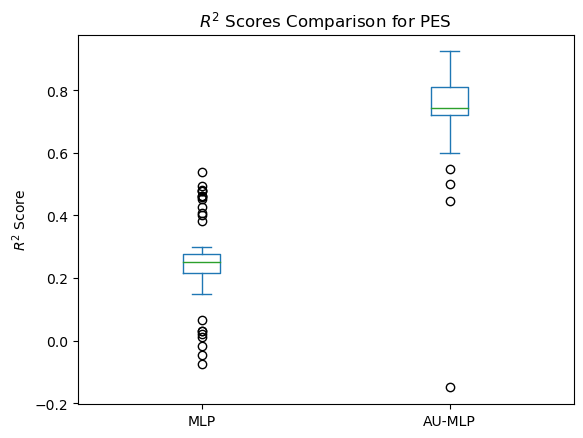

In [25]:
import matplotlib.pyplot as plt

res = real.sub(mlp_pred).pow(2).sum(axis=0)
tot = real.sub(mlp_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_mlp = 1 - res/tot
res = real.sub(unrolling_pred).pow(2).sum(axis=0)
tot = real.sub(unrolling_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_unrolling = 1 - res/tot
r2s = pd.concat([r2_mlp,r2_unrolling],axis=1).rename(columns={0:'MLP',1:'AU-MLP'})
fig, ax = plt.subplots()
r2s.plot.box(ax=ax)
ax.set_title("$R^2$ Scores Comparison for PES")
ax.set_ylabel('$R^2$ Score')
plt.show()